# Deep Convolutional GAN (DCGAN)

Generative Adversarial Networks, or GANs for short, are an approach to **Generative Modeling** using deep learning methods. Generative modeling is an unsupervised learning task in machine learning that involves automatically discovering and learning the regularities or patterns in input data in such a way that the model can be used to generate or output new examples that plausibly could have been drawn from the original dataset.

The GAN model architecture involves two sub-models: a generator model for generating new examples and a discriminator model for classifying whether generated examples are real, from the domain, or fake, generated by the generator model.
- **Generator:** Model that is used to generate new plausible examples from the problem domain.
- **Discriminator:** Model that is used to classify examples as real (from the domain) or fake (generated).

**Application of GANs:**
* Generate Examples for Image Datasets(i.e, medical data such as X-ray, MRI)
* Super Resolution
* Clothing Translation
* 3D Object Generation
* Text-to-Image Translation


Here is the implementation of a **Deep Convolutional GAN(DCGAN)** on MNIST dataset.
In this Notebook, we will see how to,
   * Load torchvision dataset
   * Create Generator network
   * Create Discriminator network
   * Train GAN
   * Evaluate GAN during training by plotting results of Generator

## Import Packages

In [ ]:
import torch
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

from torchvision.utils import make_grid

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.optim import Adam

In [ ]:
# Function to visualizing images from tensor

def show_tensor_images(tensor_img, num_img=25, size=(1, 28, 28)):
    tensor_img = (tensor_img + 1) / 2
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_img], nrow=5)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

DCGAN is a very successful and influential GAN model developed in 2015. Most GANs today are at least loosely based on the DCGAN architecture.

![DCGAN.png](attachment:DCGAN.png)

Here are the main features of DCGAN:
*   Use convolutions without any pooling layers
*   Use batchnorm in both the generator and the discriminator
*   Don't use fully connected hidden layers
*   Use ReLU activation in the generator for all layers except for the output, which uses a Tanh activation.
*   Use LeakyReLU activation in the discriminator for all layers except for the output, which does not use an activation
*   Both Generator and Discriminator use 4 layers as 3 hidden layers and 1 output layer


## Load data

In these cells we are going to load MNIST dataset from torchvision datasets and apply transforms and creating Dataloader. After that visualization has been done so we can be familier with the dataset.

In [ ]:
# More transforms can be added
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = DataLoader(
    MNIST('data/', download=True, transform=transform),
    batch_size=128,
    shuffle=True)

Shape of loading one batch: torch.Size([128, 1, 28, 28])
Total no. of batches present in trainloader: 469


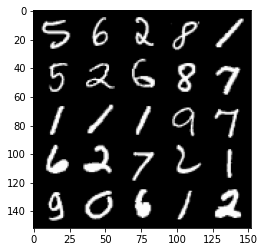

In [ ]:
# Display images from train_loader

dataiter = iter(train_loader)
images,labels = dataiter.next()
print('Shape of loading one batch:', images.shape)
print('Total no. of batches present in trainloader:', len(train_loader))

show_tensor_images(images)

## Generator

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_dim=10, img_channel=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim * 4),
            self.gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim * 2, hidden_dim),
            self.gen_block(hidden_dim, img_channel, kernel_size=4, final_layer=True),
        )

    def gen_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Generator of DCGAN, corresponding to
            - Transposed Convolution
            - Batchnorm (except for in the last layer)
            - Activation
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace=True)
                
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channel, output_channel, kernel_size, stride),
                nn.Tanh()
                
            )

    def forward(self, x):
        x = x.view(len(x), self.z_dim, 1, 1)
        # change the shape: (batch_size, channels=z_dim, width=1, height=1)
        return self.gen(x)


## Discriminator

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, img_channel=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.disc_block(img_channel, hidden_dim, kernel_size=4),
            self.disc_block(hidden_dim, hidden_dim * 2),
            self.disc_block(hidden_dim * 2, hidden_dim * 4, kernel_size=4, stride=1),
            self.disc_block(hidden_dim * 4, 1, final_layer=True),
        )

    def disc_block(self, input_channel, output_channel, kernel_size=3, stride=2, final_layer=False):
        '''
        Function that return a basic Sequential block for the Discriminator of DCGAN, corresponding to
            - Convolution
            - Batchnorm (except for in the last layer)
            - LeakyReLU activation with 0.2 slope of the leak
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size, stride),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(0.2, inplace=True)
                
            )
        else:
            return nn.Sequential(
                 nn.Conv2d(input_channel, output_channel, kernel_size, stride)
                
            )
  
    def forward(self, image):
       discriminator_prediction = self.disc(image)
       return discriminator_prediction.view(len(discriminator_prediction), -1) # returns 1-dimension tensor representing fake/real

## Initialize Generator and Discriminator


In [ ]:
# required parameters for training

z_dim = 64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

G = G.apply(weights_init)
D = D.apply(weights_init)

In [ ]:
## Define loss and Optimizer 
beta_1 =  0.475        # parameters control the optimizer's momentum
beta_2 =  0.979     # parameters control the optimizer's momentum

G_opt = Adam(G.parameters(),lr=0.0005, betas=(beta_1, beta_2))
D_opt = Adam(D.parameters(), lr=0.0005, betas=(beta_1, beta_2))

# 'BinaryCrossEntropy Loss' is used to evaluate how well dicriminator and generator performs
def real_loss(disc_pred):
  norm = nn.BCEWithLogitsLoss()
  error = norm(disc_pred, torch.ones_like(disc_pred))
  return error

def fake_loss(disc_pred):
  norm = nn.BCEWithLogitsLoss()
  error = norm(disc_pred, torch.zeros_like(disc_pred))
  return error

## Training

Here's roughly progression of DCGAN. On GPU this takes about 17-18 seconds per thousand steps. On CPU, this can take more than 4 hours per thousand steps.

![MNIST_DCGAN_Progression.png](attachment:MNIST_DCGAN_Progression.png)

In [ ]:
display_step = 100     # how often to display/visualize the images

epochs = 15
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

  0%|          | 0/469 [00:00<?, ?it/s]

Step 100: Generator loss: 0.7668765980005264, discriminator loss: 0.5720167556405069


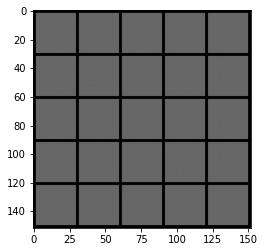

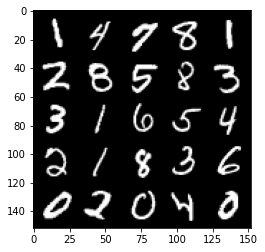

Step 200: Generator loss: 1.5104285919666294, discriminator loss: 0.22089997142553328


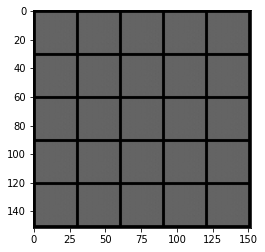

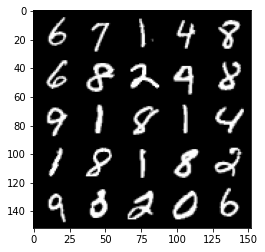

Step 300: Generator loss: 2.880450282096862, discriminator loss: 0.05910163696855307


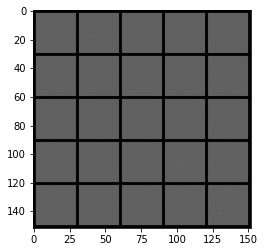

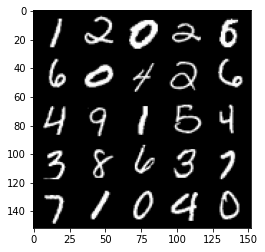

Step 400: Generator loss: 4.120460846424103, discriminator loss: 0.01684669161215425


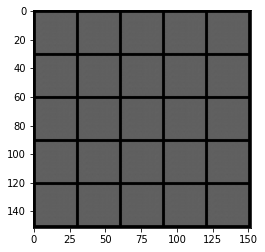

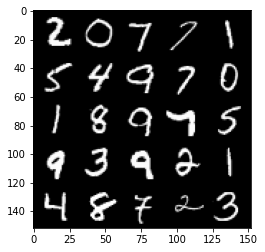

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 5.325237674713134, discriminator loss: 0.004997825468890372


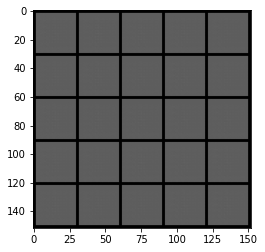

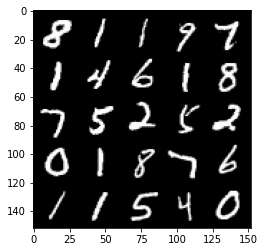

Step 600: Generator loss: 6.502597365379333, discriminator loss: 0.0016051628498826174


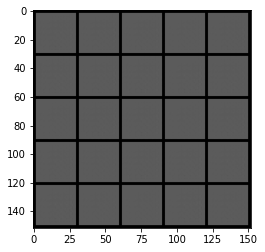

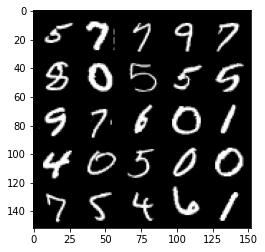

Step 700: Generator loss: 7.6104958868026715, discriminator loss: 0.0005190963810309769


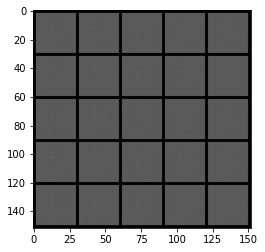

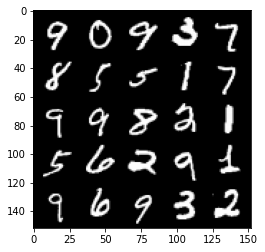

Step 800: Generator loss: 8.913511734008786, discriminator loss: 0.0002554761336068623


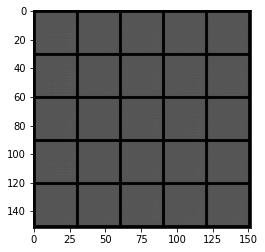

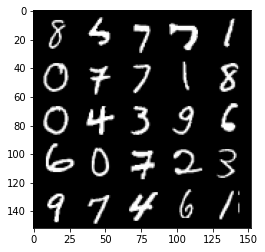

Step 900: Generator loss: 9.864593706130979, discriminator loss: 8.673471518704896e-05


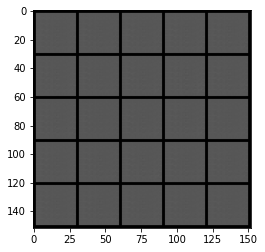

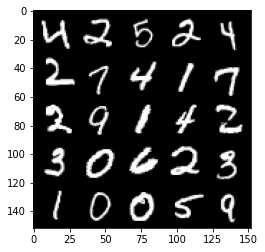

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 10.685999593734742, discriminator loss: 2.997490312736773e-05


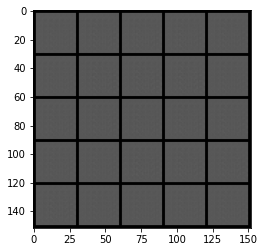

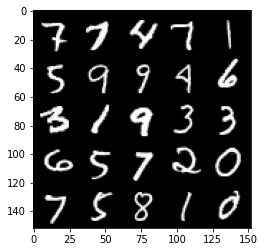

Step 1100: Generator loss: 11.993596143722534, discriminator loss: 2.045711833034148e-05


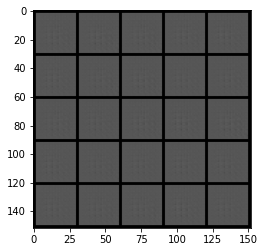

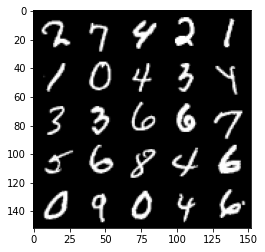

Step 1200: Generator loss: 12.700947809219366, discriminator loss: 5.460673323796073e-06


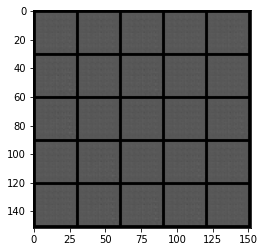

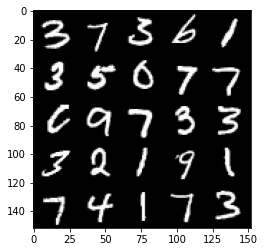

Step 1300: Generator loss: 14.03612627983094, discriminator loss: 2.0268151774871516e-06


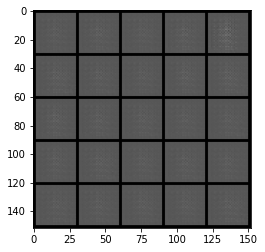

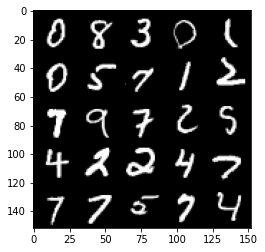

Step 1400: Generator loss: 15.008260726928714, discriminator loss: 1.0671885306123845e-06


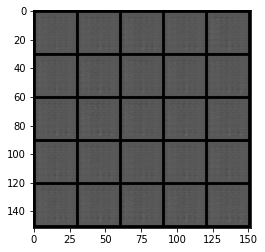

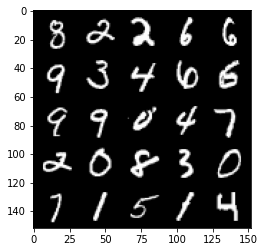

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 15.840240354537968, discriminator loss: 2.715708586720212e-07


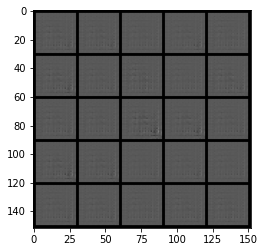

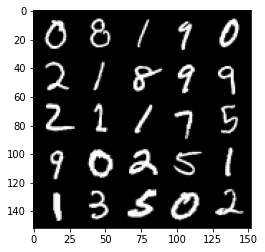

Step 1600: Generator loss: 16.836809558868403, discriminator loss: 0.000321973953680832


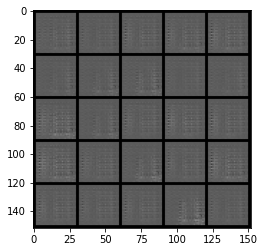

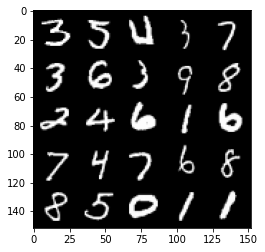

Step 1700: Generator loss: 7.899461342096327, discriminator loss: 0.291096206225484


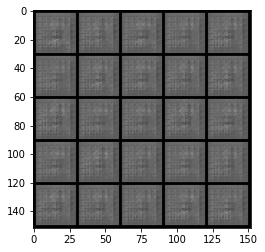

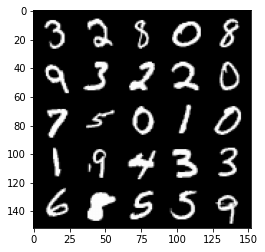

Step 1800: Generator loss: 6.19165594100952, discriminator loss: 0.011352251658681775


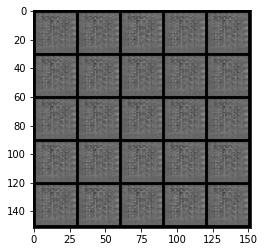

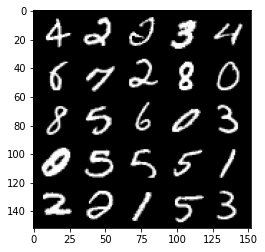

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1900: Generator loss: 6.284005942780057, discriminator loss: 0.2710466527577955


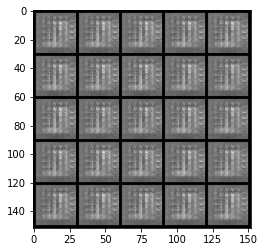

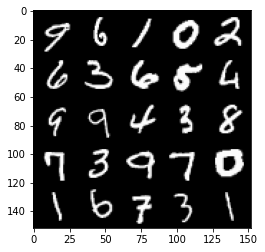

Step 2000: Generator loss: 5.547745707035065, discriminator loss: 0.19122127799317237


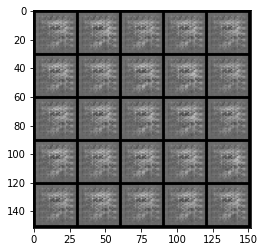

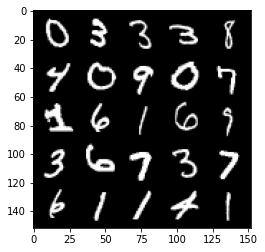

Step 2100: Generator loss: 5.1939620757102976, discriminator loss: 0.22598194565624


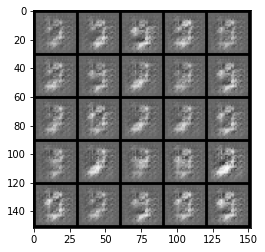

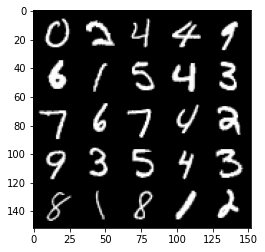

Step 2200: Generator loss: 4.240386289358139, discriminator loss: 0.21526507094502445


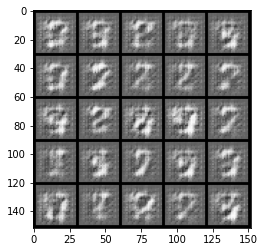

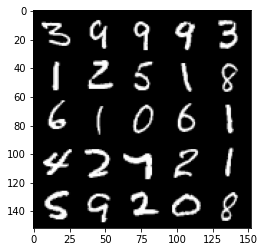

Step 2300: Generator loss: 3.2803759008646, discriminator loss: 0.2980114769935609


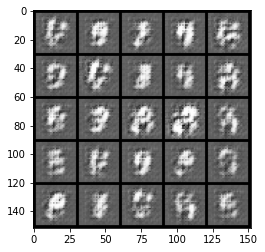

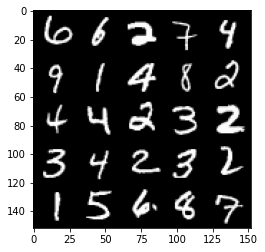

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2400: Generator loss: 2.804910878539086, discriminator loss: 0.22793771162629126


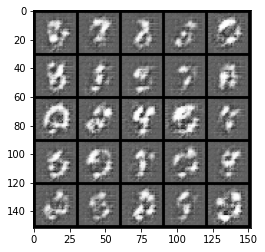

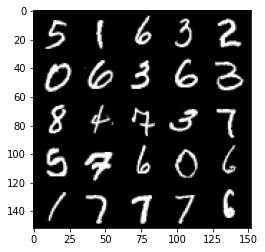

Step 2500: Generator loss: 2.5655645287036912, discriminator loss: 0.269214435070753


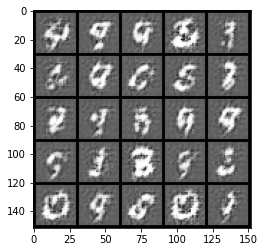

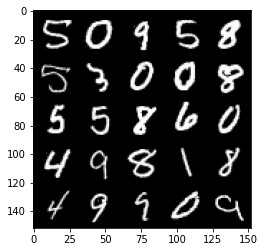

Step 2600: Generator loss: 2.4945182025432584, discriminator loss: 0.33056070938706383


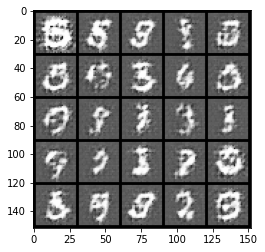

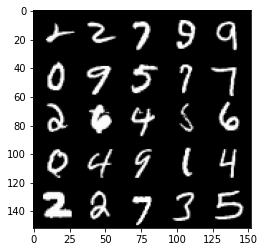

Step 2700: Generator loss: 2.195040627121925, discriminator loss: 0.25961867034435265


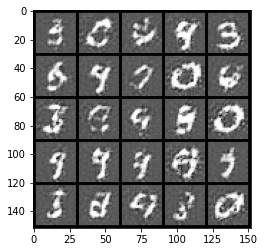

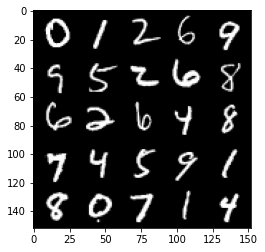

Step 2800: Generator loss: 2.1761481088399885, discriminator loss: 0.36887215510010724


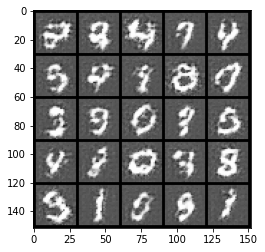

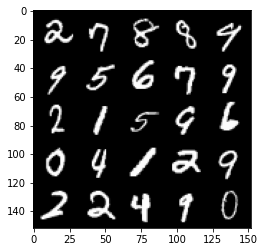

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2900: Generator loss: 2.0392991822957995, discriminator loss: 0.3504444636404514


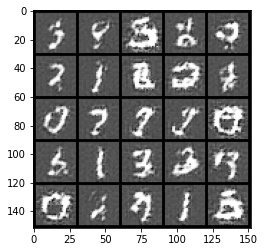

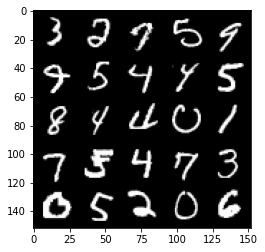

Step 3000: Generator loss: 1.9312696754932406, discriminator loss: 0.3399730610847472


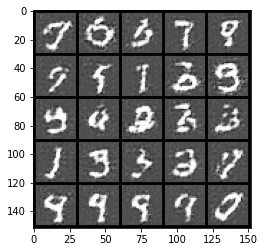

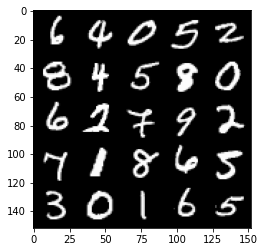

Step 3100: Generator loss: 1.918788821101188, discriminator loss: 0.3464362458884716


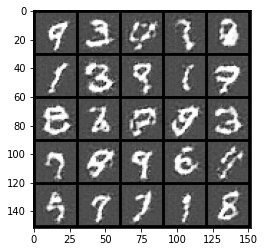

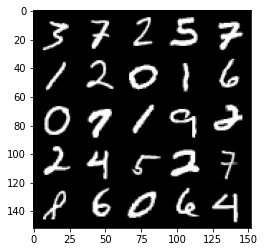

Step 3200: Generator loss: 1.9285950887203227, discriminator loss: 0.3592890158295633


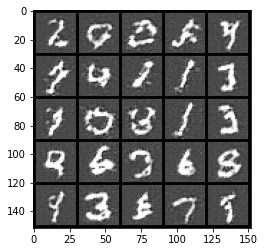

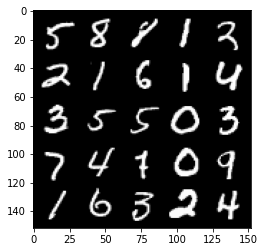

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3300: Generator loss: 1.8586429876089106, discriminator loss: 0.3648961970210073


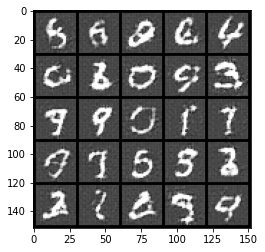

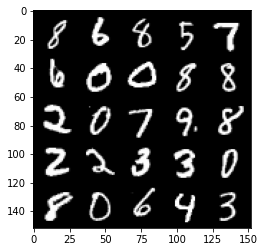

Step 3400: Generator loss: 1.8132683011889459, discriminator loss: 0.3620458249747753


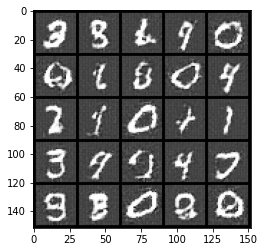

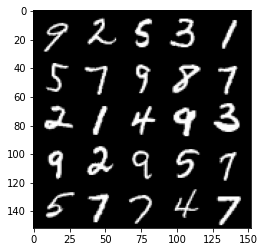

Step 3500: Generator loss: 1.7987521785497669, discriminator loss: 0.36119296193122885


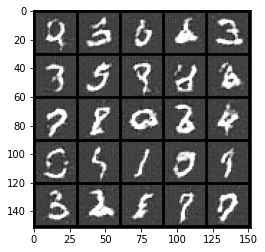

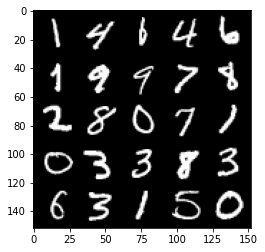

Step 3600: Generator loss: 1.7305991384387018, discriminator loss: 0.40142517834901814


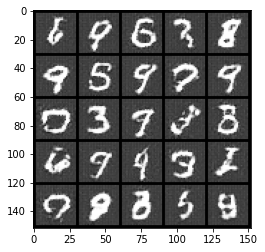

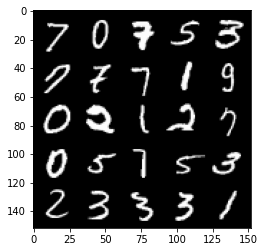

Step 3700: Generator loss: 1.7080508455634118, discriminator loss: 0.36322507202625276


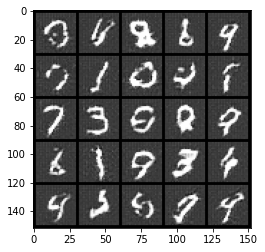

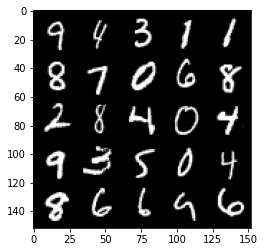

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3800: Generator loss: 1.7135586068034172, discriminator loss: 0.37602993845939636


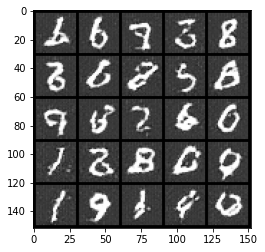

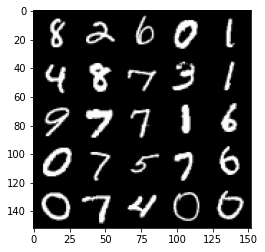

Step 3900: Generator loss: 1.6989805141091345, discriminator loss: 0.37966671228408827


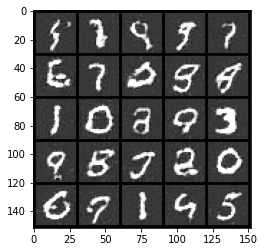

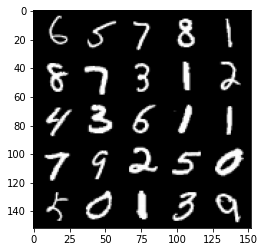

Step 4000: Generator loss: 1.7025612658262255, discriminator loss: 0.39961770743131625


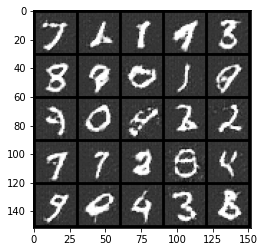

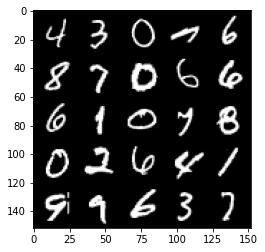

Step 4100: Generator loss: 1.6376538118720056, discriminator loss: 0.3825432610511778


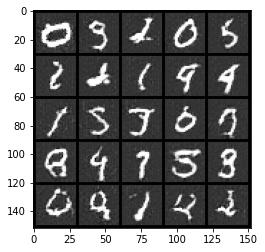

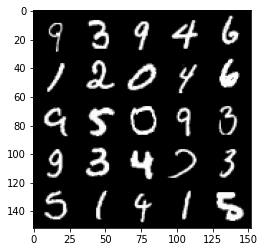

Step 4200: Generator loss: 1.6323459517955776, discriminator loss: 0.39820532143115994


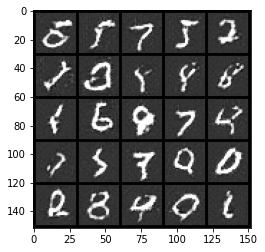

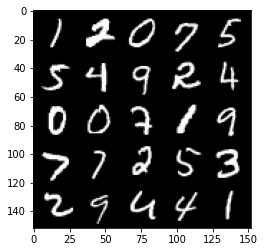

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4300: Generator loss: 1.6389831691980363, discriminator loss: 0.40415080100297923


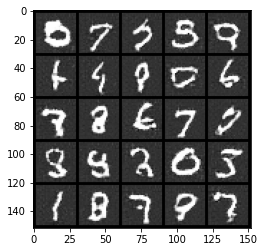

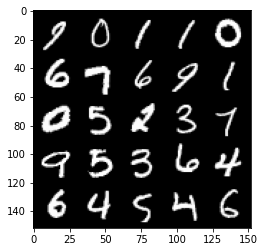

Step 4400: Generator loss: 1.58082555949688, discriminator loss: 0.395808317363262


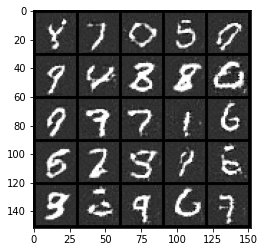

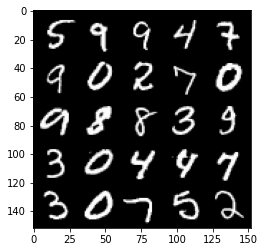

Step 4500: Generator loss: 1.5789538761973387, discriminator loss: 0.420388205051422


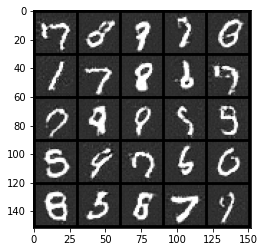

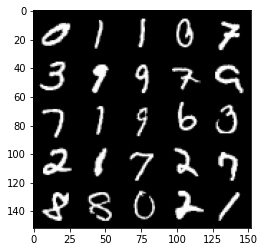

Step 4600: Generator loss: 1.5775064927339553, discriminator loss: 0.4108405089378357


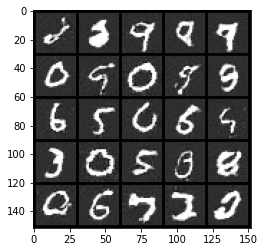

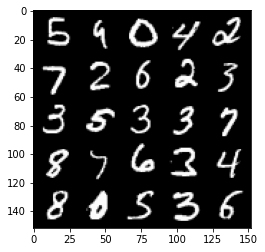

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4700: Generator loss: 1.5495699331164354, discriminator loss: 0.41165412396192563


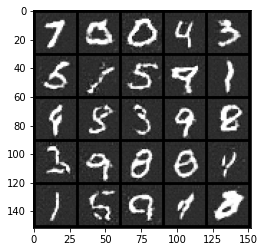

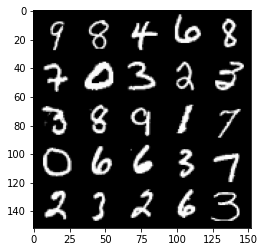

Step 4800: Generator loss: 1.5524380917847165, discriminator loss: 0.41166678637266163


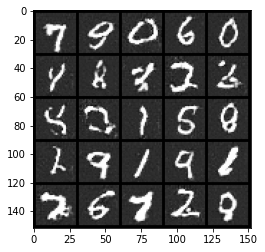

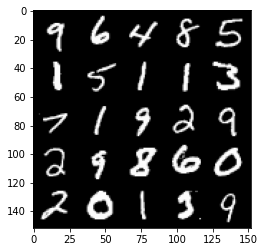

Step 4900: Generator loss: 1.5471445780992503, discriminator loss: 0.4126835745573043


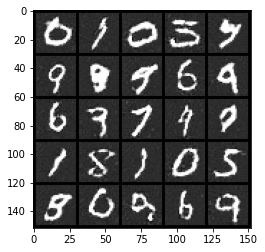

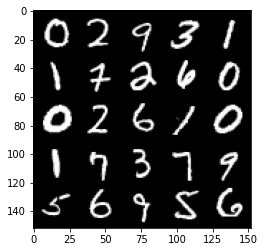

Step 5000: Generator loss: 1.5099801349639892, discriminator loss: 0.4258220854401588


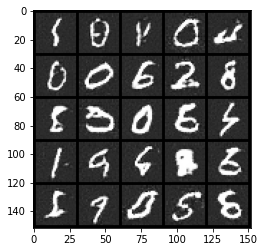

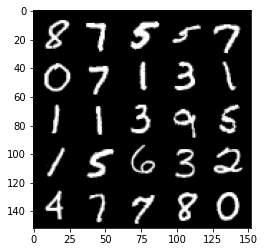

Step 5100: Generator loss: 1.529862017631531, discriminator loss: 0.41731319516897203


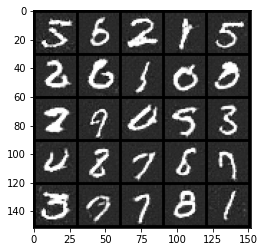

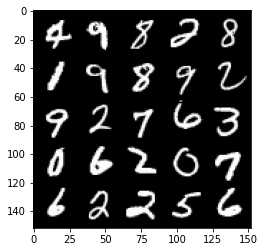

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5200: Generator loss: 1.5029463228583333, discriminator loss: 0.4404834663867949


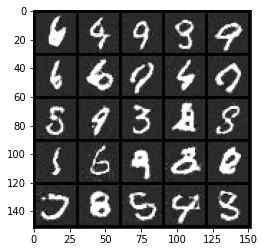

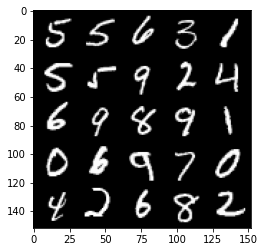

Step 5300: Generator loss: 1.5299229452013967, discriminator loss: 0.42779117137193684


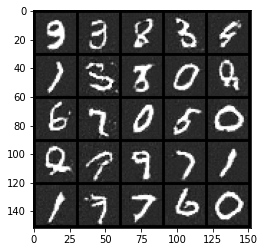

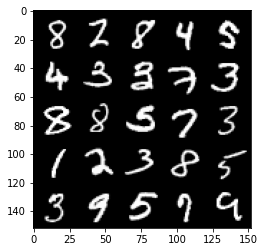

Step 5400: Generator loss: 1.4778357049822808, discriminator loss: 0.4311242851614952


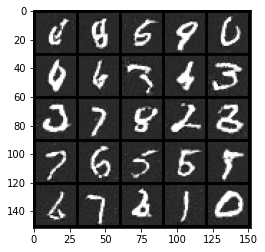

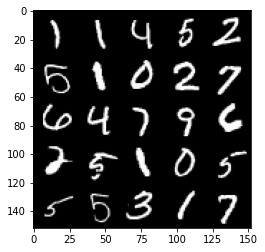

Step 5500: Generator loss: 1.4915308851003646, discriminator loss: 0.42482091426849367


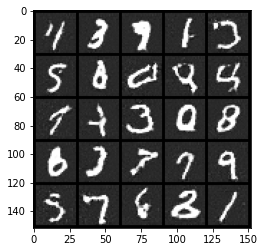

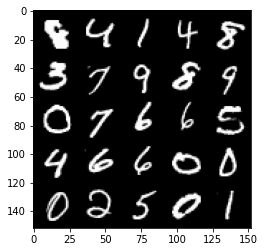

Step 5600: Generator loss: 1.4990261286497122, discriminator loss: 0.4430188056826592


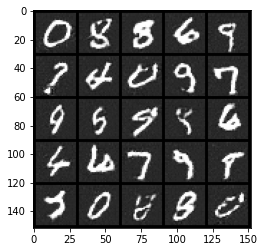

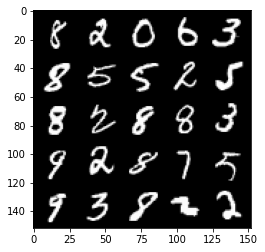

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5700: Generator loss: 1.5164183849096298, discriminator loss: 0.4388127526640891


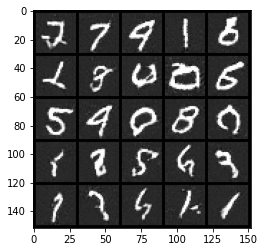

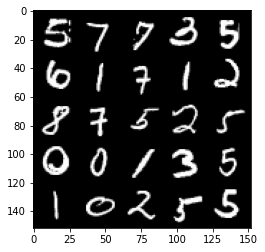

Step 5800: Generator loss: 1.48406182706356, discriminator loss: 0.4355102545022964


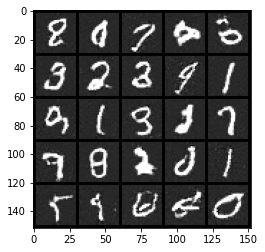

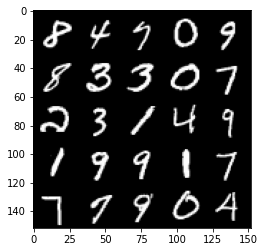

Step 5900: Generator loss: 1.4439019641280177, discriminator loss: 0.4569801345467569


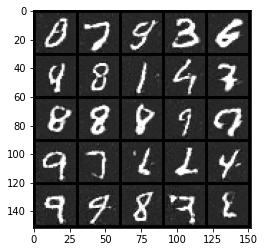

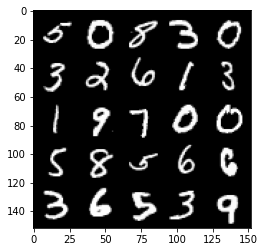

Step 6000: Generator loss: 1.446914944052696, discriminator loss: 0.45858675926923764


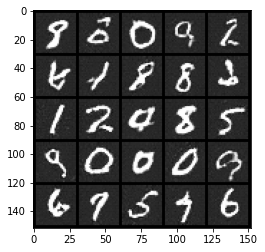

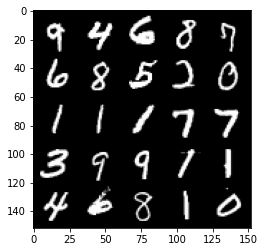

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6100: Generator loss: 1.4173158434033388, discriminator loss: 0.46113248616456975


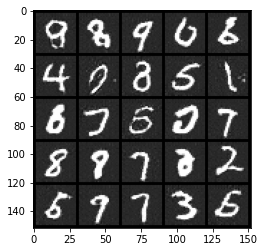

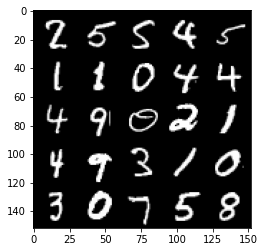

Step 6200: Generator loss: 1.4304363924264907, discriminator loss: 0.4493639194965365


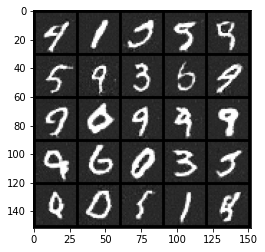

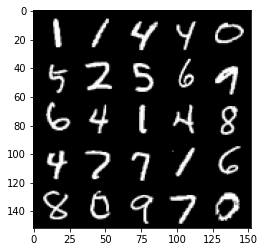

Step 6300: Generator loss: 1.393858935236931, discriminator loss: 0.4586751770973203


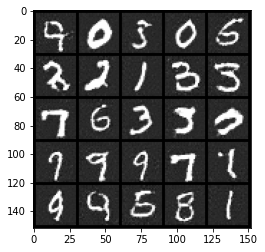

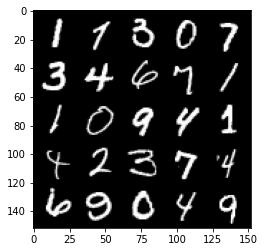

Step 6400: Generator loss: 1.422688513994217, discriminator loss: 0.46195620745420446


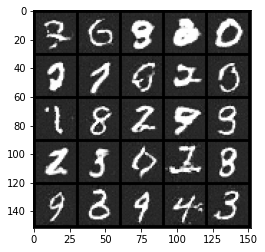

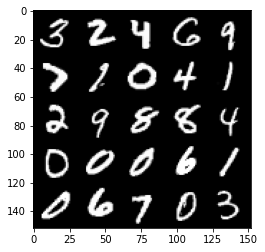

Step 6500: Generator loss: 1.4210694807767859, discriminator loss: 0.4663740044832229


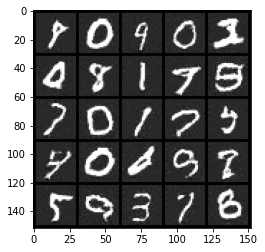

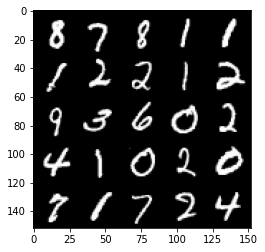

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6600: Generator loss: 1.4295790517330176, discriminator loss: 0.4641081163287163


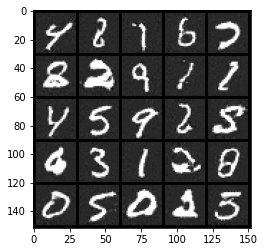

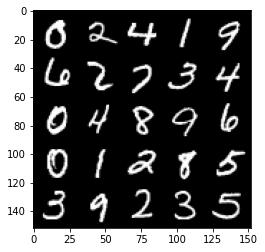

Step 6700: Generator loss: 1.4212084013223645, discriminator loss: 0.453192736208439


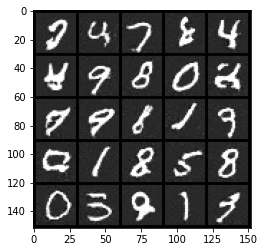

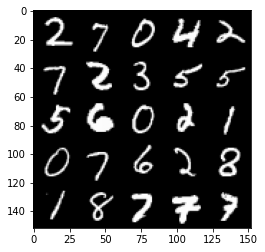

Step 6800: Generator loss: 1.4023268237709998, discriminator loss: 0.4698949527740477


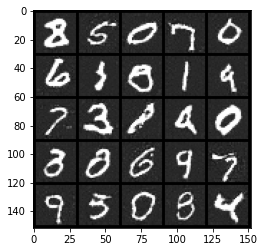

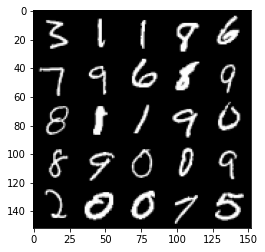

Step 6900: Generator loss: 1.3810034602880479, discriminator loss: 0.4686908817291261


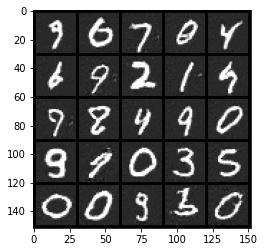

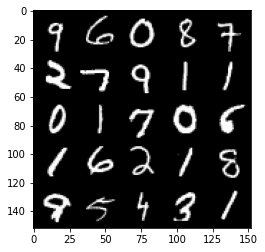

Step 7000: Generator loss: 1.3570851910114288, discriminator loss: 0.48255981355905514


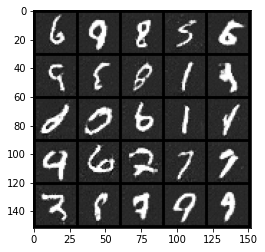

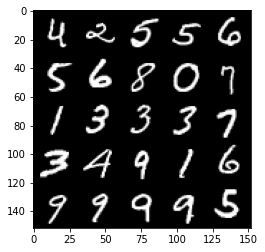

In [ ]:
for epoch in range(epochs):
  for real_img,_ in tqdm(train_loader):
    batch_size = real_img.size(0)
    real_img = real_img.to(device)

    #  Update Discriminator  #
    D_opt.zero_grad()
    noise = torch.randn(batch_size, z_dim, device=device)
    fake_img =G(noise) #Generate noise and pass it through the generator
    D_pred =  D(fake_img.detach())#Pass real and fake images through the discriminator
    D_fake_loss= fake_loss(D_pred)# required parameters for training

    D_pred = D(real_img) #Pass real and fake images through the discriminator
    D_real_loss =  real_loss(D_pred)#Calculate the loss for the real images
    D_loss =  (D_fake_loss + D_real_loss) / 2#Calculate the loss for the discriminator
    mean_discriminator_loss = mean_discriminator_loss + D_loss.item() / display_step    # Keep track of the average discriminator loss


    #Backward pass for the discriminator
    D_loss.backward(retain_graph=True)
    D_opt.step()

    # Update Generator #
    G_opt.zero_grad()
    #Reset the gradients for the generator
    noise =  torch.randn(batch_size, z_dim, device=device) #Generate noise
    fake_img =  G(noise)#Pass noise through the generator
    D_pred =  D(fake_img)#Pass fake images through the discriminator
    G_loss =  real_loss(D_pred)#Calculate the loss for the generator
    mean_generator_loss += G_loss.item() / display_step     # Keep track of the average generator loss

    #Backward pass for the generator
    G_loss.backward()
    G_opt.step()


    # Visualization #
    if cur_step % display_step == 0 and cur_step > 0:
        print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(fake_img)
        show_tensor_images(real_img)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
    cur_step += 1


## Create more samples

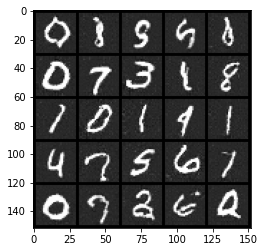

In [ ]:
num_image = 60
noise = torch.randn(num_image, z_dim, device=device)
with torch.no_grad():
    fake_img = G(noise)
show_tensor_images(fake_img)